# Predicting Newsletter Subscription from Minecraft Gameplay Behavior
DSCI 100 – Group 11 Final Report


## Introduction


#### Background

Newsletters are commonly used in games to share updates and community information.
Some players choose to subscribe while others do not, and this difference may relate to player characteristics.
Our goal was to explore whether simple demographic information collected from players of `PLAICraft.ai` could help explain subscription behaviour.

#### Research Questions

`Broad Question`: 

What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

`Specific Question`: 

Can Age and Experience predict subscription rate?

#### Dataset
The `player.csv`  dataset contains information describing the users. It is contains 196 observations (users) and 7 variables about them. 


| Variable | Type | Meaning |  |
|---|---|---|---|
experience | chr | experience level of player | "Pro", "Veteran", "Regular", "Amateur", "Beginner" |
subscribe | lgl| player is subscribed to newsletter or not | TRUE or FALSE |
hashedEmail | chr | player email as identifier | hashed for anonymity
played_hours | dbl | total hours played in game |
name | chr | player name |
gender | chr | player gender | Male, Female, Non-binary, Two-Spirited, Agender, Other, Prefer not to say |
Age | dbl | player age | 9 - 58 |

###### *Table 1*

#### Libraries

The necessary libraries for the analysis are loaded.

In [28]:
library(tidyverse)
library(tidymodels)
library(themis)
library(cowplot)

#### Load and Wrangle `Players.csv`

Through a url to the dataset in the Github repository, the `players.csv` dataset is loaded. The dataset also contains NA values which are removed, and the `subscribe` and `experience` variables are converted into factors.

In [2]:
player_data <- read_csv("https://raw.githubusercontent.com/PraiseBeTheSun/DSCI-100-GROUP-PROJECT/refs/heads/main/data/players.csv")

player_data <- player_data |>
filter(Age != is.na(Age)) |>
mutate(subscribe = as.factor(subscribe),
       experience = as.factor(experience))

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### `Players.csv` Summary

##### Numerical Columns

The summary statistics mean, minimum, maximum, standard deviation, mode and quartiles of the numerical columns (`Age`, `played_hours`) are computed.

In [29]:
player_data_age_hours <- select(player_data,played_hours, Age)

player_data_numeric_summaries <- 
    bind_cols(summary = c("Mean","Minimum","Maximum", "Standard Deviation", "Mode",
                          "1st Quartile", "2nd Quartile", "3rd Quartile"),
              bind_rows(map_df(player_data_age_hours, mean, na.rm = TRUE), #mean
                        map_df(player_data_age_hours, range, na.rm = TRUE), #min + max
                        map_df(player_data_age_hours, sd, na.rm = TRUE), #std dev
                        
                        bind_cols(played_hours = group_by(player_data_age_hours, played_hours) |>  #mode
                                          summarize(count = n()) |>slice_max(count) |> pull(played_hours), 
                                  Age = group_by(player_data_age_hours, Age) |> summarize(count = n()) |>
                                          slice_max(count) |> pull(Age)),
                        tibble(played_hours = quantile(pull(player_data_age_hours,played_hours), #quartiles
                                                       c(0.25, 0.5, 0.75), na.rm = TRUE),
                               Age = quantile(pull(player_data_age_hours,Age), 
                                              c(0.25, 0.5, 0.75), na.rm = TRUE)))) |>
    mutate(across(played_hours:Age, round, 2)) #rounding

player_data_numeric_summaries

summary,played_hours,Age
<chr>,<dbl>,<dbl>
Mean,5.9,21.14
Minimum,0.0,9.00
Maximum,223.1,58.00
Standard Deviation,28.5,7.39
Mode,0.0,17.00
1st Quartile,0.0,17.00
2nd Quartile,0.1,19.00
3rd Quartile,0.6,22.75


##### Non-numeric Columns

The number of observations of each distinct value and the percentage of observations they represent is computed for `experience`, `subscribe` and `gender`.

In [4]:
player_data_category <- select(player_data, experience, subscribe, gender)

experience_summary <- player_data_category |> group_by(experience) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2))
subscribe_summary <- player_data_category |> group_by(subscribe) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2))                      
gender_summary <- player_data_category |> group_by(gender) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2)) 

experience_summary
subscribe_summary
gender_summary

experience,number,percent_total
<fct>,<int>,<dbl>
Amateur,63,32.47
Veteran,48,24.74
Beginner,35,18.04
Regular,35,18.04
Pro,13,6.70


subscribe,number,percent_total
<fct>,<int>,<dbl>
TRUE,142,73.2
FALSE,52,26.8


gender,number,percent_total
<chr>,<int>,<dbl>
Male,124,63.92
Female,37,19.07
Non-binary,15,7.73
Prefer not to say,11,5.67
Two-Spirited,5,2.58
Agender,2,1.03


#### Exploratory Visualizations

##### Experience vs Subscription — Proportion Plot

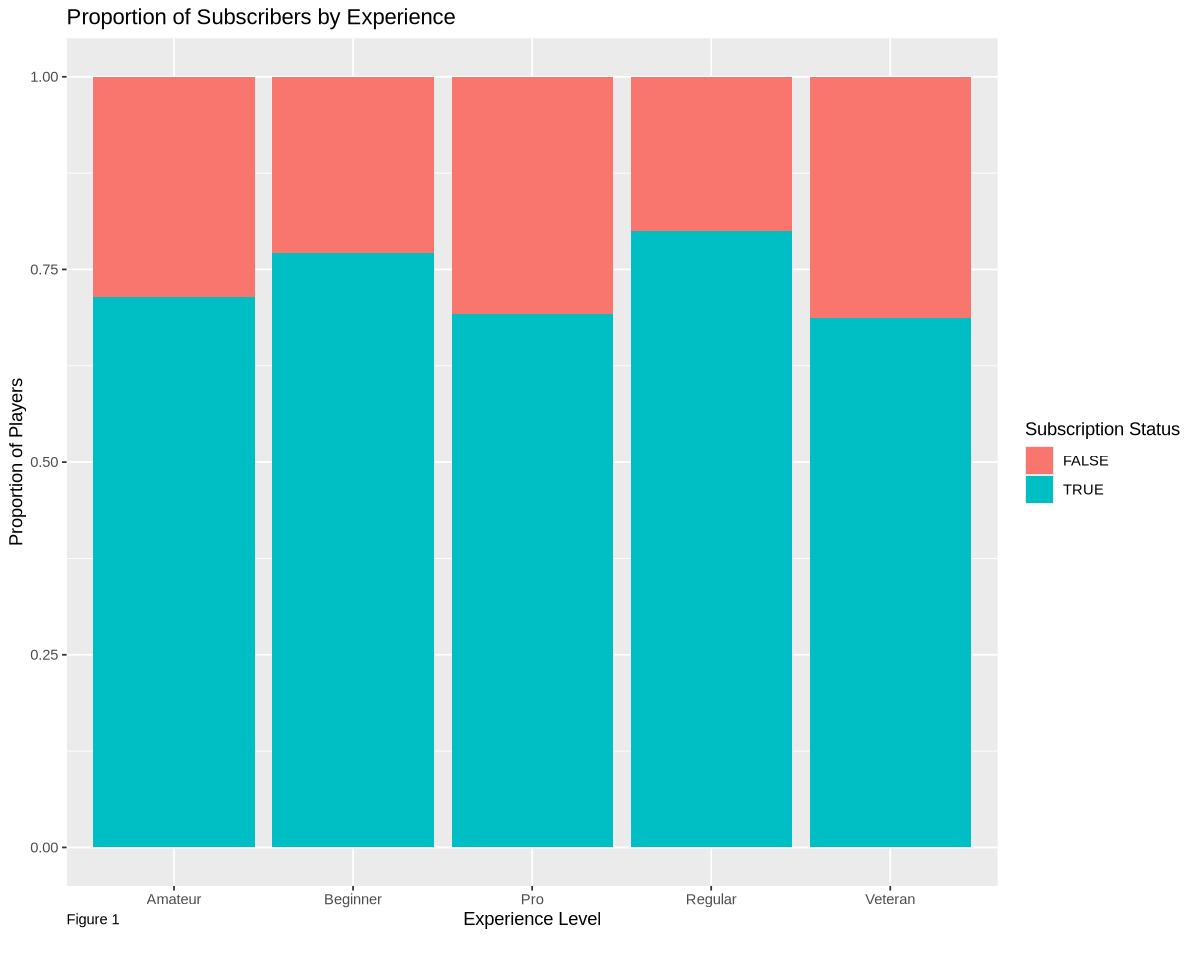

In [5]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(player_data, aes(x = experience, fill = subscribe)) +
geom_bar(position = "fill") +
labs(title = "Proportion of Subscribers by Experience", 
     x = "Experience Level", 
     y = "Proportion of Players",
    fill = "Subscription Status",
    caption = "Figure 1") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

The proportion of subscribed vs not subscribed players is roughly the same across experience levels as seen in figure 1. This may indicate that experience is not a strong predictors of whether a player is likely to subscribe.

##### Experience vs Subscription — Count Plot

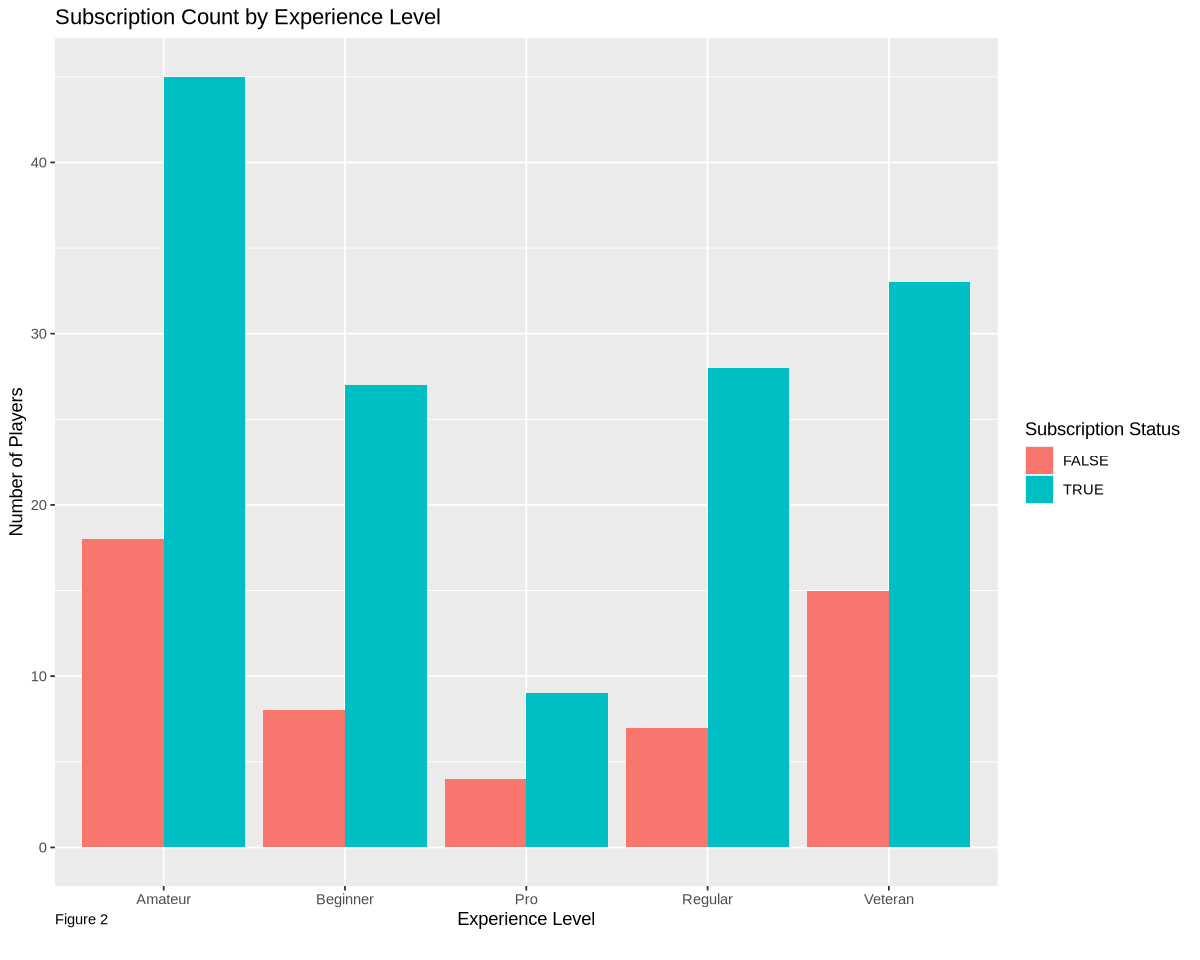

In [6]:
ggplot(player_data, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(title = "Subscription Count by Experience Level",
       x = "Experience Level",
       y = "Number of Players",
      fill = "Subscription Status",
      caption = "Figure 2") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

The number of total players per experience level is not equal across them (as seen in figure 2), potentially leading to the model having difficulty predicting the less represented experience levels such as "Pro".

##### Age vs Subscription — Quartile Distribution Plot

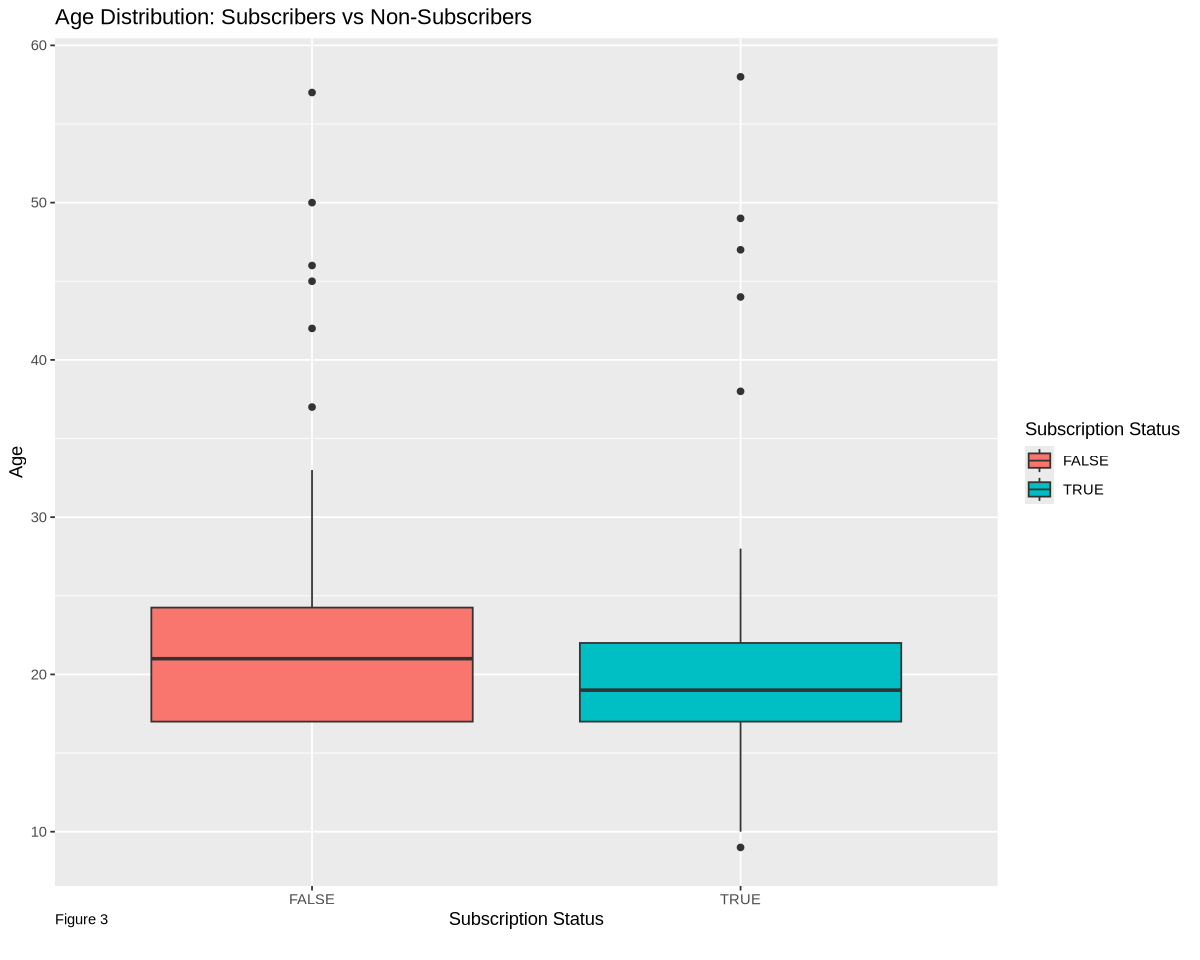

In [7]:
ggplot(player_data, aes(x = subscribe, y = Age, fill = subscribe)) +
  geom_boxplot() +
  labs(title = "Age Distribution: Subscribers vs Non-Subscribers",
       x = "Subscription Status",
       y = "Age",
       fill = "Subscription Status",
      caption = "Figure 3") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

The median age for subscribed players is lower for those who subscribe than those who do not and the interquartile is also more compact than the interquartile for non subscribed players.

##### Age vs Subscription — Count Plot

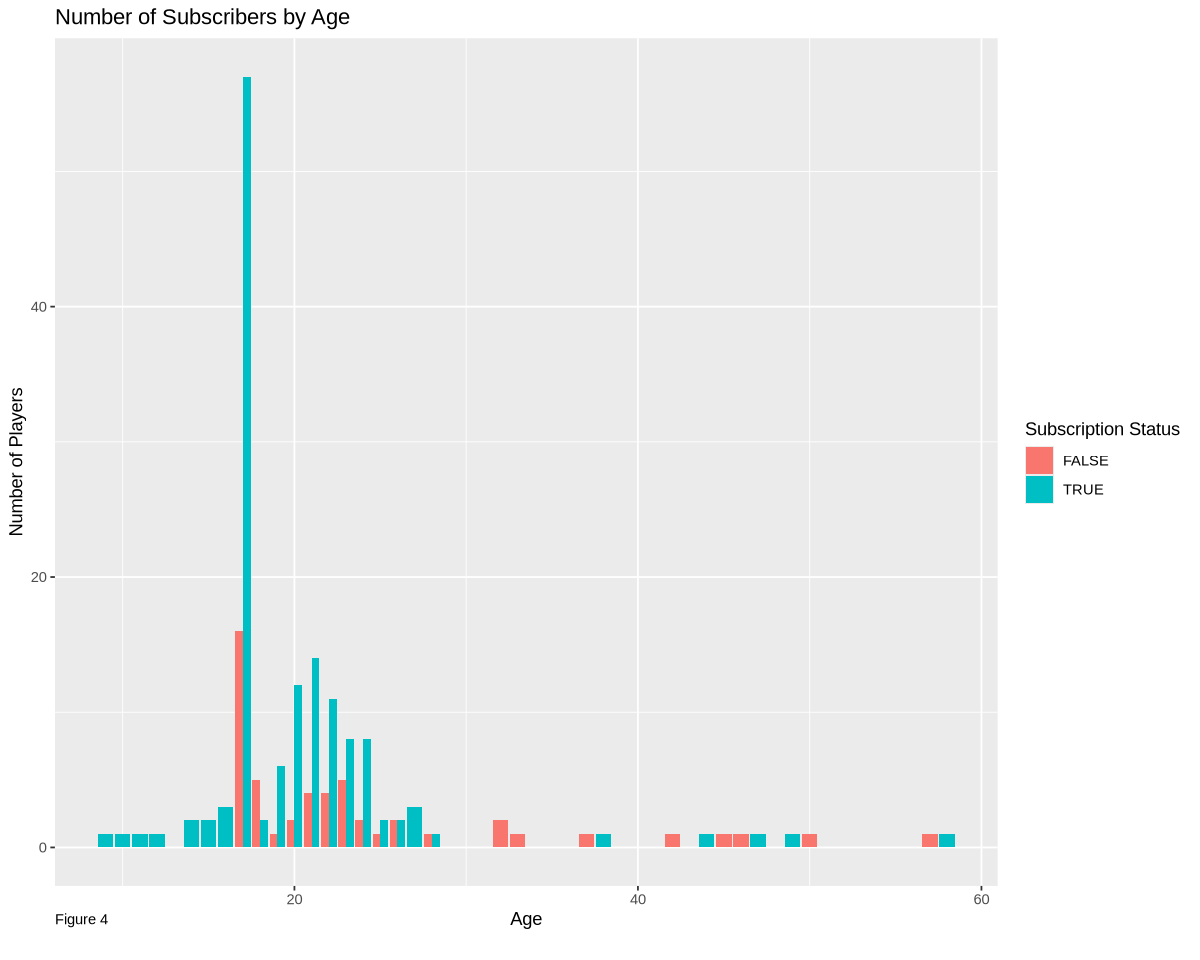

In [8]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(player_data, aes(x = Age, fill = subscribe)) +
geom_bar(position = "dodge") +
labs(title = "Number of Subscribers by Age", 
     x = "Age", 
     y = "Number of Players",
    fill = "Subscription Status",
    caption = "Figure 4") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

The majority of player ages are between 10 and 30, with 17 being the age with the most players.

#### Trainng and Testing Split and 5-fold Data Separation

Here the `player_data` is split into 75% training and  25% testing datasets, then the training portion is grouped into 5 folds for later use in cross validation.

In [9]:
set.seed(1)
player_split <- initial_split(player_data, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

#### K-NN Classification Models

Individual recipes were created for `Age`, `experience` and `Age` + `experience`, where the `Age` predictor was stardardized for each recipe it is present in. These recipes were used as a manual forward selection process to determine the best combination of the the two variables to be used in the final classification model. A tuning model was also created and used along with the recipes and odd K values from 1 to 75 to determine the resulting accuracy via cross validation at each K value based on each recipe.

In [10]:
k_vals <- tibble(neighbors = seq(from = 1, to = 75, by = 2))

knn_recipe_age <- recipe(subscribe ~ Age, data = player_train) |>
                step_normalize(all_predictors())

knn_recipe_experience <- recipe(subscribe ~ experience, data = player_train)

knn_recipe_both <- recipe(subscribe ~ Age + experience, data = player_train) |>
                step_normalize(Age)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

age_tune <- workflow() |>
            add_recipe(knn_recipe_age) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

experience_tune <- workflow() |>
            add_recipe(knn_recipe_experience) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

both_tune <- workflow() |>
            add_recipe(knn_recipe_both) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

#### K-NN Tune Model Plots

Created visualizations of the accuracy at each K value for each model formed by the individual recipes. 

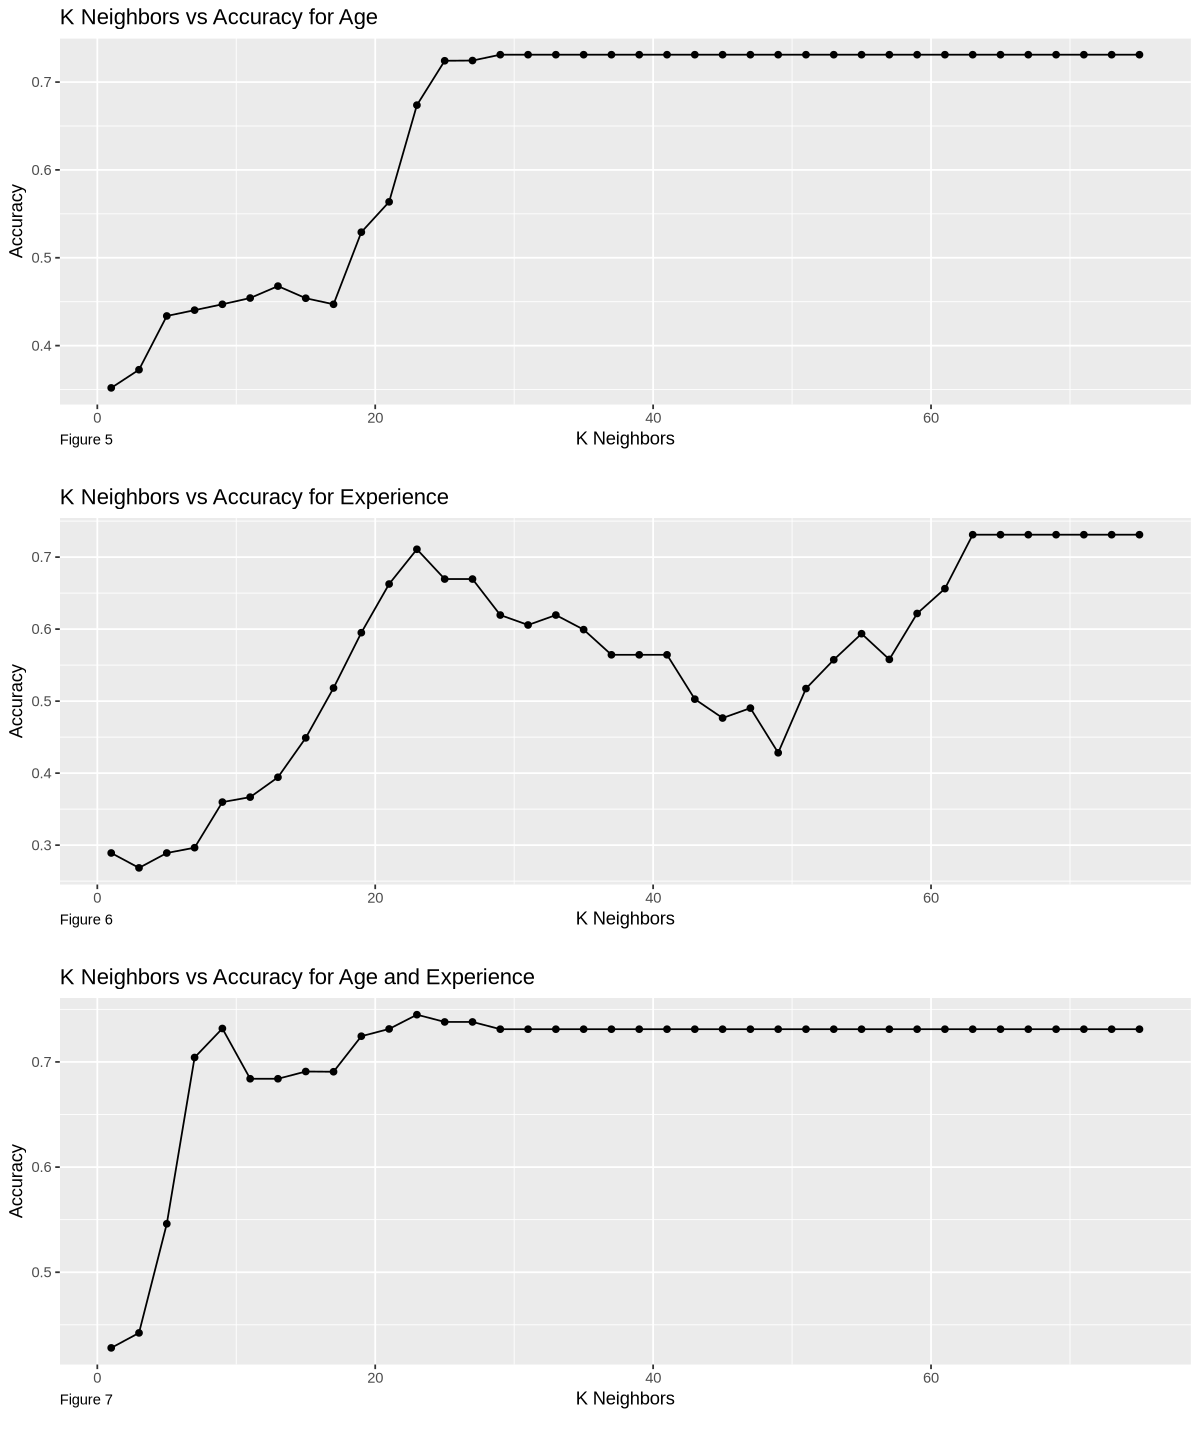

In [11]:
options(repr.plot.width = 10, repr.plot.height = 12)
age_tune_plot <- age_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 5") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

experience_tune_plot <- experience_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Experience", 
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 6") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

both_tune_plot <- both_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age and Experience",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 7") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

plot_grid(age_tune_plot,
          experience_tune_plot,
          both_tune_plot, ncol = 1)

### Tuning Results
*Age Only Plot:*
- Accuracy doesn't have a clear peak
- As K increases past 13, accuracy drops, then begins to spike up at k = 17.
- Starting at K = 29, accuracy flattens out all the way to K = 75, indicating the model is underfitting.
- Age does not seem to separate subscribers from non-subscribers meaningfully

*Experience Only Plot:*
- Accuracy peaks at around K = 23
- As K increases past 23, accuracy drops erratically, reaching a relative low at k = 49 before again spiking up and underfitting
- Experience seems to have a stronger influence on the model than age, however it does not appear that it has much of a relationship with subscribe, since the accuracy of the model is erratic.

*Age and Experience Plot:*
- Highest overall accuracy value
- Accuracy peaks at around K = 23
- As K increases past 9, accuracy dips briefly before climbing to reach it peak
- As K increases past 29, accuracy flattens out all the way to K = 75, indicating the model is underfitting.
- Combined, both predictors seem to have improved performance, with accuracy being slightly higher than just using `Age` or `Experience`

#### Select Predictors and K Value

Find the K value(s) with the highest accuracy for each model.

In [12]:
max_age_accuracy <- age_tune |> 
                slice_max(mean)
max_experience_accuracy <- experience_tune |>
                        slice_max(mean)
max_both_accuracy <- both_tune |>
                    slice_max(mean)
# max_age_accuracy        # <- max accuracy = 0.7311494 @ 29-75 neighbors
# max_experience_accuracy # <- max accuracy = 0.7311494 @ 63-75 neighbors
# max_both_accuracy       # <- max accuracy = 0.7449425 @ 23 neighbors

The `Age` and `experience` model was chosen since it has the highest accuracy of the three models and K = 23 was selected for it because it has the greatest accuracy and the surrounding points do not have drastically different accuracies.

#### K-NN Model and Prediction

A classification model is created with 23 neighbors, trained on the `player_train` dataset, and the model is used on the `player_test` dataset to predict the `subscribe` values.

In [13]:
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) |>
                set_engine("kknn") |>
                set_mode("classification")

knn_fit <- workflow() |>
            add_recipe(knn_recipe_both) |>
            add_model(knn_spec_tuned) |>
            fit(player_train)


player_predict <- predict(knn_fit, player_test) |>
                bind_cols(player_test)

#### Proportion of Subcribe Values in `player_test`

In [14]:
player_test |> group_by(subscribe) |> summarize(proportion = n()/nrow(player_test))

subscribe,proportion
<fct>,<dbl>
FALSE,0.2653061
TRUE,0.7346939


###### *Table 2*

#### Accuracy of Model

In [15]:
prediction_accuracy <- player_predict |>
                        metrics(truth = subscribe, estimate = .pred_class) |>
                        filter(.metric == "accuracy")
prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


###### *Table 3*

The accuracy of the model is the same number as the proportion of *TRUE* subscribe values in the `player_test` dataset. If the model were to blindly "predict" only *TRUE*, it would have the same accuracy, therefore making it a not very effective classification model.

#### Precision and Recall (*TRUE* as Positive)

In [16]:
prediction_precision_t <- player_predict |> # TRUE is the second event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "second")

prediction_recall_t <- player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "second")
bind_rows(prediction_precision_t, prediction_recall_t)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7555556
recall,binary,0.9444444


###### *Table 4*

The recall is fairly high, however "predicting" all *TRUE* would actually yeild a better recall, since every *TRUE* value would be correctly predicted. In terms of precision, this is were the model is slightly better than just predicting *TRUE*. Based on the fact that the precision is higher than the proportion of *TRUE* values, it implies that the model had some correct *FALSE* predictions.

#### Precision and Recall (*FALSE* as Positive)

In [17]:
prediction_precision_f <- player_predict |> # FALSE is the first event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "first")

prediction_recall_f <- player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "first")
bind_rows(prediction_precision_f, prediction_recall_f)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.5000000
recall,binary,0.1538462


###### *Table 5*

A precision of .500 means the model correctly predicted *False* 50% of the time, and a recall of 0.154 means very few of the *FALSE* values were predicted *FALSE*.

#### Confusion Matrix of Model

In [18]:
prediction_conf_mat <- player_predict |>
                        conf_mat(truth = subscribe, estimate = .pred_class)
prediction_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     2    2
     TRUE     11   34

###### *Table 6*

From the confusion matrix in table 5, it can be seen that *TRUE* was predicted 45 out of 49 times; however, of the 45 predictions, only 34 where correct. *FALSE* was predicted only 4 times, and only 2 of those were correct. The bias to mostly predicting *TRUE* is most likely due to the imbalance of *TRUE* and *FALSE* values in `subscribe` which can be addressed through upsampling. Additionally, overall there are few observations in the dataset which limits how well the model can be trained.

#### Upsample Training Data and 5-fold Data Separation

Set the seed to ensure reproducablity, then created a recipe to upsample and the training dataset, before preping and baking it to the training dataset to make a 1:1 ratio of *TRUE* and *FALSE*. Then created the 5 fold separation with the upsampled data.

In [19]:
set.seed(1)
player_train_upsampled <- recipe(subscribe ~ Age + experience, data = player_train) |>
                            step_upsample(subscribe, over_ratio = 1, skip = TRUE) |>
                             prep(retain = TRUE) |>
                             bake(new_data = NULL)

player_vfold_upsampled <- vfold_cv(player_train_upsampled, v = 5, strata = subscribe)

#### Upsampled K-NN Models

Same process as with the original model, expect the upsampled training dataset is used.

In [20]:
balanced_knn_recipe_age <- recipe(subscribe ~ Age, data = player_train_upsampled) |>
                            step_normalize(all_predictors())

balanced_knn_recipe_experience <- recipe(subscribe ~ experience, data = player_train_upsampled)

balanced_knn_recipe_both <- recipe(subscribe ~ Age + experience, data = player_train_upsampled) |>
                            step_normalize(Age)


balanced_age_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_age) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

balanced_experience_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_experience) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

balanced_both_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_both) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 


#### K-NN Tune Model Plots of Upsampled

Same process as with the original model, expect the upsampled training dataset is used.

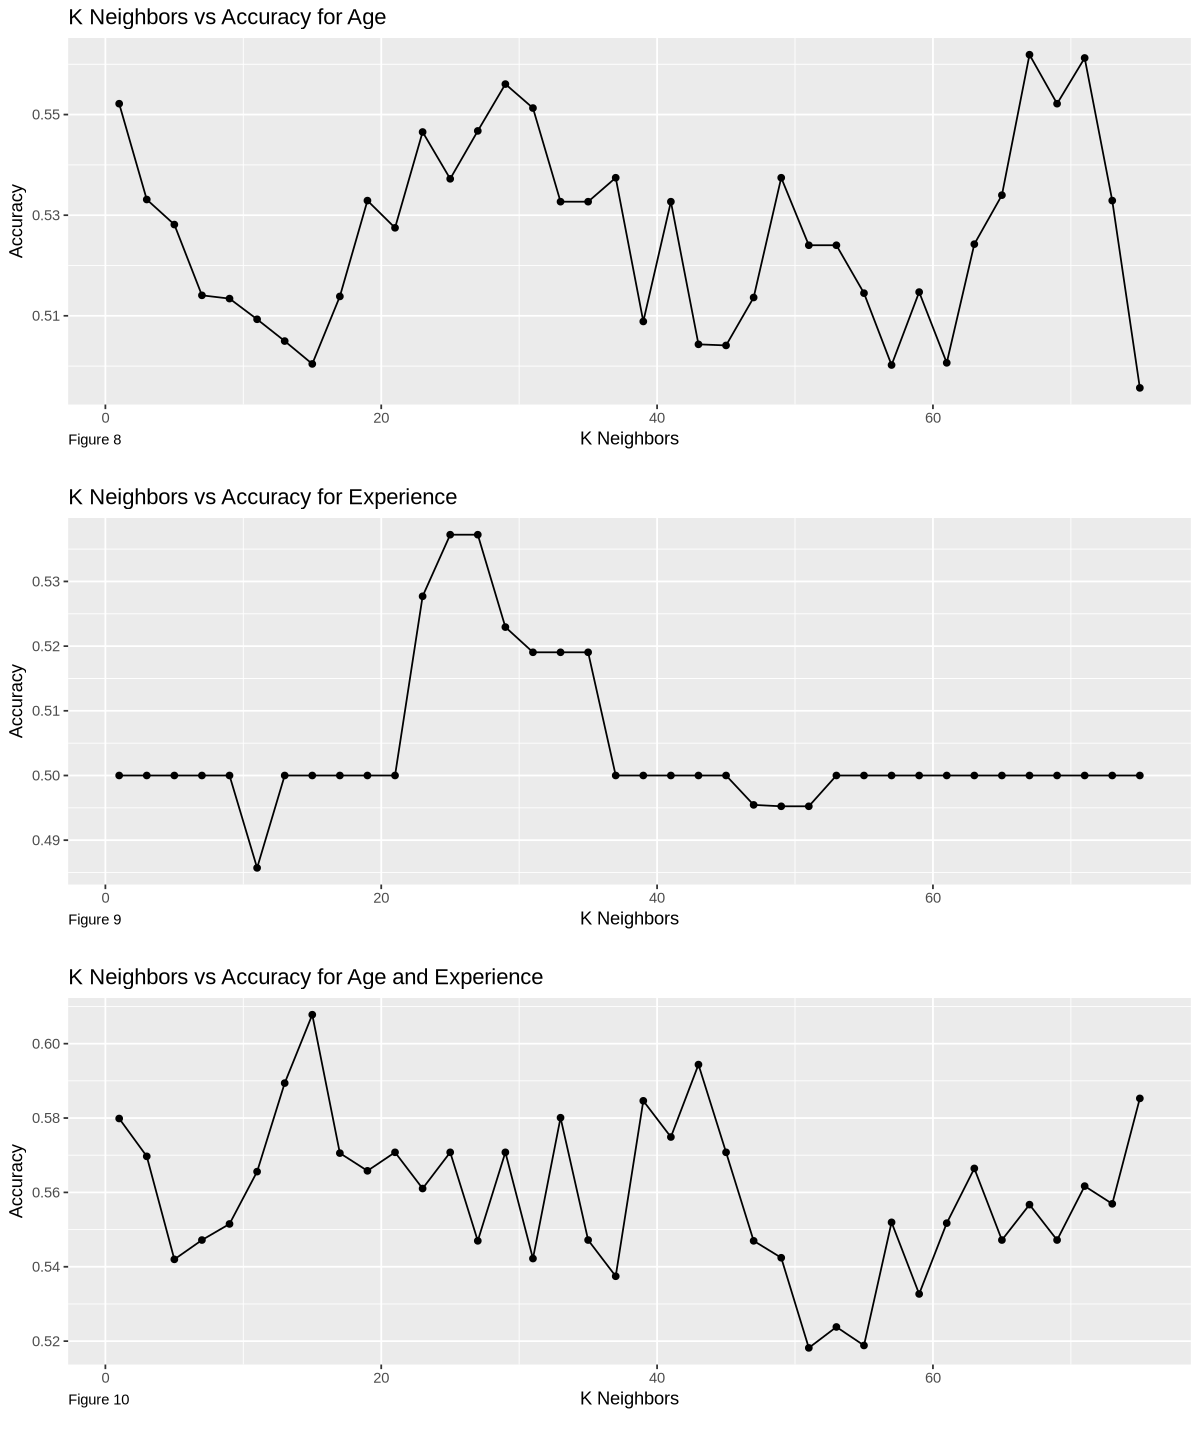

In [21]:
options(repr.plot.width = 10, repr.plot.height = 12)
balanced_age_tune_plot <- balanced_age_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 8") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

balanced_experience_tune_plot <- balanced_experience_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Experience",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 9") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

balanced_both_tune_plot <- balanced_both_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age and Experience",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 10") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

plot_grid(balanced_age_tune_plot,
          balanced_experience_tune_plot,
          balanced_both_tune_plot, ncol = 1)

After upsampling, our predictions differ a bit. Both predictors seem pretty weak, only being about 50-60% accurate. However, using both predictors gives us the highest accuracy of around 61% at K = 15, showing that the predictors do seem to have partial relation to subscription. Perhaps if the sample size was larger, we can confidently determine whether these variables are strong predictors or not.

#### Select Predictors and K Value of Upsampled

In [22]:
balanced_max_age_accuracy <- balanced_age_tune |> 
                slice_max(mean)
balanced_max_experience_accuracy  <- balanced_experience_tune |>
                        slice_max(mean)
balanced_max_both_accuracy  <- balanced_both_tune |>
                    slice_max(mean)
# balanced_max_age_accuracy       # <- max accuracy  = 0.5619048 @ 67 neighbors
# balanced_max_experience_accuracy  # <- max accuracy  = 0.5372294 @ 25-27 neighbors
# balanced_max_both_accuracy        # <- max accuracy  = 0.6077922 @ 15 neighbors

Although K = 15 has the highest accuracy for this model, as can be seen in figure 10, it is located at a large spike with the surronding K values' accuracy being quite lower; inidcating it is not a reliable choice and may not perform as well on other data, therefore the being a suboptimal choice. The highest peak with the least variation before and after the point is the optimal K value to select, and from figure 10, that value is K = 21 since the 4 nearest points only change a maximum of ~0.01. Due to this reasoning, K = 21 will be used in the upsampled model.

#### Upsampled K-NN Model and Prediction

Created a K-NN classification model using 21 neighbors, then along with the recipe using `Age` and `experience` predictors from the upsampled training data, fit it to the upsampled training data. That model was then used to predict the `subscribe` values in the original `player_test` data.

In [23]:
balanced_knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
                set_engine("kknn") |>
                set_mode("classification")

balanced_knn_fit <- workflow() |>
            add_recipe(balanced_knn_recipe_both) |>
            add_model(balanced_knn_spec_tuned) |>
            fit(player_train_upsampled)

balanced_player_predict <- predict(balanced_knn_fit, player_test) |>
                bind_cols(player_test)

#### Accuracy of Upsampled Model

In [24]:
balanced_prediction_accuracy <- balanced_player_predict |>
                        metrics(truth = subscribe, estimate = .pred_class) |>
                        filter(.metric == "accuracy")
balanced_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6122449


###### *Table 7*

The accuracy of the upsampled model (0.612) is lower than the accuracy of the original model (0.735) which in general implies it is worse.

#### Precision and Recall of Upsampled Model (*TRUE* as Positive)

In [25]:
balanced_prediction_precision_t <- balanced_player_predict |> # TRUE is the second event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "second")

balanced_prediction_recall_t <- balanced_player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "second")

bind_rows(balanced_prediction_precision_t, balanced_prediction_recall_t)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8148148
recall,binary,0.6111111


###### *Table 8*

From table 8, it can be seen that the precision for *TRUE* of the upsampled model (0.815) is higher than the original model (0.756), meaning it predicted *TRUE* when the actual value was *FALSE* fewer times. In contrast, recall is lower since the upsampled model correctly predicted *TRUE* fewer times.

#### Precision and Recall of Upsampled Model (*FALSE* as Positive)

In [26]:
balanced_prediction_precision_f <- balanced_player_predict |> # FALSE is the first event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "first")

balanced_prediction_recall_f <- balanced_player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "first")

bind_rows(balanced_prediction_precision_f, balanced_prediction_recall_f)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.3636364
recall,binary,0.6153846


###### *Table 9*

*FALSE* was predicted for *TRUE* values more times than in the original model, leading to a lower precision (shown in table 9). Recall however, is significantly better, indicating this model is better at correctly predicting if a player will not subscribe.

#### Confusion Matrix of Upsampled Model 

In [27]:
balanced_prediction_conf_mat <- balanced_player_predict |>
                        conf_mat(truth = subscribe, estimate = .pred_class)
balanced_prediction_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     8   14
     TRUE      5   22

###### *Table 10*

As seen in table 10, the upsampled model predicted *TRUE* 27 out of 49 times. Of those 27 *TRUE* predictions, 22 were correct, and of its 22 *False* predictions, 8 were correct. This model had much more distribution to its predictions as opposed to the original model mostly predicting *TRUE*.

### Discussion:

*Summarize what you found:*
- We found that `Experience` and `Age` can seemingly predict newsletter subscription. We found that using both `Experience` and `Age` is the most accurate, followed by `Experience` alone, and then `Age` alone. However, after being upsampled, `Age` is around the same as `Experience`, both having abyssmally low accuracies of around 55%.

*Is this what we expected to find?:*
- This is expected, as in our individual project, visualizations showed that different `Experience` levels had very similar subscription proportions, meaning not much predictability between different experience levels. `Age` also seems pretty weak as a predictor, with a seemingly pretty weak relation with subscription.

*Discuss what impact such findings could have:*
- Advertisers can use this information to cater to a targeted age or gaming experience audience for Minecraft-related material.
- New studies can go more in-depth at the relation between Age and Experience level

*Discuss what future questions this could lead to:*
- Can `gender` or `played_hours` also predict newsletter subscription?